# (G8) Seq2seq으로 번역기 만들기

****

# 프로젝트: 한영 번역기 만들기

## Step 1. 데이터 다운로드

- 아래 링크에서 ```korean-english-park.train.tar.gz```를 다운로드받아 한영 병렬 데이터를 확보한다.
- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
```c
$ wget https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz
```

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [3]:
# 프로젝트에 사용될 라이브러리 import
import tensorflow as tf
import numpy as np

import matplotlib.ticker as ticker

import time
import re
import os
import io

import pandas as pd
import urllib.request
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

print(tf.__version__)

2.4.1


In [4]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw_ko = f.read().splitlines()

path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.en'

with open(path_to_file, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size:", len(raw_ko))
print("Data Size:", len(raw_en))

print("Example:")
for sen_ko, sen_en in zip(raw_ko[0:100][::20], raw_en[0:100][::20]): 
    print(">>", sen_ko, sen_en)

Data Size: 94123
Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?" Much of personal computing is about "can you top this?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다. Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다." “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다. Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다. Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the ki

## Step 2. 데이터 정제

> 1) ```set```데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거하도록 한다. 데이터의 **병렬 쌍이 흐트러지지 않게 주의**하자. 중복을 제거한 데이터를 ```cleaned_corpus```에 저장한다.
>
> 2) 앞서 정의한 ```preprocessing()```함수는 한글에 대해 동작하지 않는다. **한글에 적용할 수 있는 정규식**을 추가하여 함수를 재정의하자.
>
> 3) 타겟 언어인 영문엔 ```<start>``` 토큰과 ```<end>``` 토큰을 추가하고 ```split()```함수로 토큰화한다. 한글 토큰화는 KoNLPy의 ```mecab```클래스를 사용한다.
   
    
- 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸린다. 
- ```cleaned_corpus```로부터 **토큰의 길이가 40 이하인 데이터를 선별**하여 ```eng_corpus```와 ```kor_corpus```를 각각 구축하여라.

In [5]:
pallel_corpus = list(set(zip(raw_ko,raw_en)))
print(len(pallel_corpus))

pallel_corpus = pallel_corpus[:30000]

cleaned_corpus_ko = []
cleaned_corpus_en =[]

for i in range(len(pallel_corpus)):
    cleaned_corpus_ko.append(pallel_corpus[i][0])
    
for i in range(len(pallel_corpus)):
    cleaned_corpus_en.append(pallel_corpus[i][1])

for sen_ko,sen_en in zip(cleaned_corpus_ko[:100:20],cleaned_corpus_en[:100:20]): 
    print(">>", sen_ko ,sen_en)    

78968
>> 영국에서 3번째로 규모가 큰 영화제인 레즈비언 앤 게이 영화제는 런던을 시작으로 영국에 다른 40여개 지역에서 열리며 매년 대략 25만명의 관객이 이 영화제에 몰려들고 있다. It is the third largest film festival in the UK, touring in almost 40 different UK locations after London, showing to an audience of approximately 250,000 people each year.
>> 그러나 그가 지적한 대로 이 텐트는 시판용 제품이 아니며 3만유로(약 5700만원)나 하는 가격이 보통 캠핑을 즐기는 사람들의 구매 열의를 꺾는다. But as he points out, it is not a commercially available product, and the price tag of 30,000 euros usually dampens the enthusiasm of the average camper.
>> 인도네시아와 다른 빈국들은 종종 자국에서 발견되는 바이러스 샘플을 이용해 제약 회사들이 결국 자신들이 살 수 없는 벡신을 생산할 수 있다는 우려를 나타냈다. Indonesia and other poor countries have often expressed concerns that some independent experts say are justified that samples from viruses in their country are used to make vaccines by drug companies that they then cannot afford to buy.
>> 부시 대통령은 용종 제거수술을 받기 위해 대통령 권한을 딕 체니 부통령에게 2시간 5분 동안 넘겼었다. Nothing occurred during the 2 hours and 5 minutes of the transfer that required Cheney to t

In [6]:
from konlpy.tag import Mecab
tokenizer = Mecab()

def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    sentence = tokenizer.morphs(sentence)
    
    return sentence

def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split()
    
    return sentence

In [7]:
max_len = 40

enc_corpus = []
dec_corpus = []

for sen_ko, sen_en in zip(cleaned_corpus_ko, cleaned_corpus_en):
    if len(sen_ko) <= max_len:
        enc_corpus.append(preprocess_sentence_ko(sen_ko))
        dec_corpus.append(preprocess_sentence_en(sen_en, s_token=True, e_token=True))

print("Korean:", enc_corpus[99])  
print("English:", dec_corpus[99])  

Korean: ['한편', '윌슨', '부부', '의', '변호사', '인', '멜라니', '슬론', '은', '일', '항소', '할', '뜻', '을', '내비쳤', '다', '.']
English: ['<start>', 'melanie', 'sloan', ',', 'the', 'wilsons', 'lawyer', ',', 'said', 'the', 'couple', 'plans', 'to', 'appeal', 'thursday', 's', 'ruling', '.', '<end>']


## Step 3. 데이터 토큰화

- 앞서 정의한 ```tokenize()```함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻어라.
- 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 한다. 다만, 최소 10,000 이상이어야 한다.
- 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않는다.

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [9]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train = enc_tensor
dec_train = dec_tensor

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 10374
English Vocab Size: 10417


In [10]:
print(enc_tensor[10])
print(dec_tensor[10])

[  63    5  348   12 1516   11    3  494   17  705    6 1818    9    2
    1    0    0    0    0    0    0    0    0    0]
[   1 2579  590 3399  106    5   10   39   46   24  444    5   65   17
  131    3    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


## Step 4. 모델 설계

- 한국어를 영어로 잘 번역해 줄 멋진 **Attention 기반 Seq2seq 모델**을 설계해라.
- 앞서 만든 모델에 Dropout모듈을 추가하면 성능이 더 좋아질 것이다.
- ```Embedding Size```와 ```Hidden Size```는 실험을 통해 적당한 값을 맞춰 주도록 한다.

In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [22]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 512)
Decoder Output: (64, 10418)
Decoder Hidden State: (64, 512)
Attention: (64, 40, 1)


## Step 5. 훈련하기

- 훈련엔 위에서 사용한 코드를 그대로 사용하되, ```eval_step()```부분이 없음에 유의하자.
- 매 스텝 아래의 예문에 대한 번역을 생성하여 **본인이 생각하기에 가장 멋지게 번역한 Case를 제출**하여라
- Attention Map을 시각화해보는 것도 권고 사항이다.

    
*참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있다.*
    

```c
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
```

In [23]:
# Optimizer와 Loss 구현하기
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # tf.math.logical_not(x)는 NOT x의 원소별 참값(True value)을 반환
    # tf.math.equal는 (x == y)의 원소별 참값(True value)을 반환
    # --> real이 0인 원소별 참값을 반환 한 것에 NOT를 붙여 원소별로 논리값을 뒤집음
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype) # 텐서를 새로운 형태로 캐스팅
    loss *= mask # loss = loss*mask
    
    return tf.reduce_mean(loss)

In [24]:
# train_step 구현하기
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [44]:
# 훈련하기
from tqdm import tqdm
import random 

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 20: 100%|██████████| 96/96 [00:22<00:00,  4.29it/s, Loss 1.3950]


In [61]:
# 평가하기
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([str(sentence).split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(str(result).split()), :len(str(sentence).split())]
    plot_attention(attention, str(sentence).split(), str(result).split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: <end> 


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


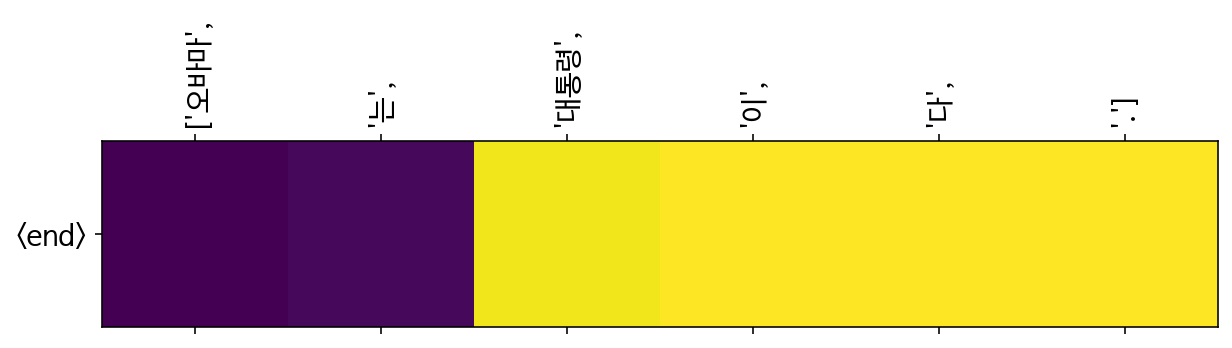

In [62]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: <end> 


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


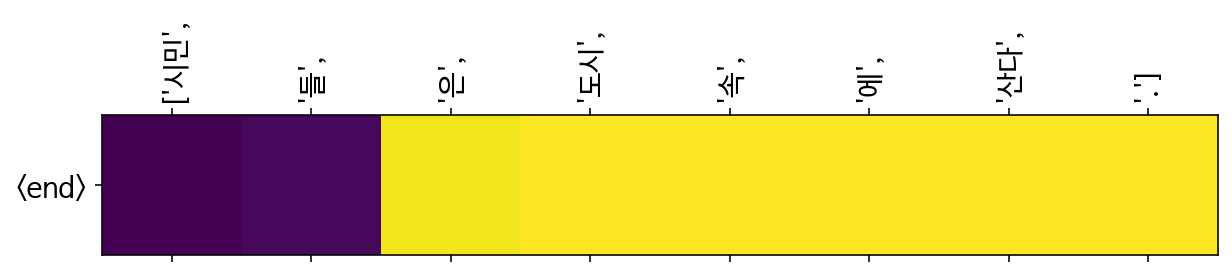

In [63]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: <end> 


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


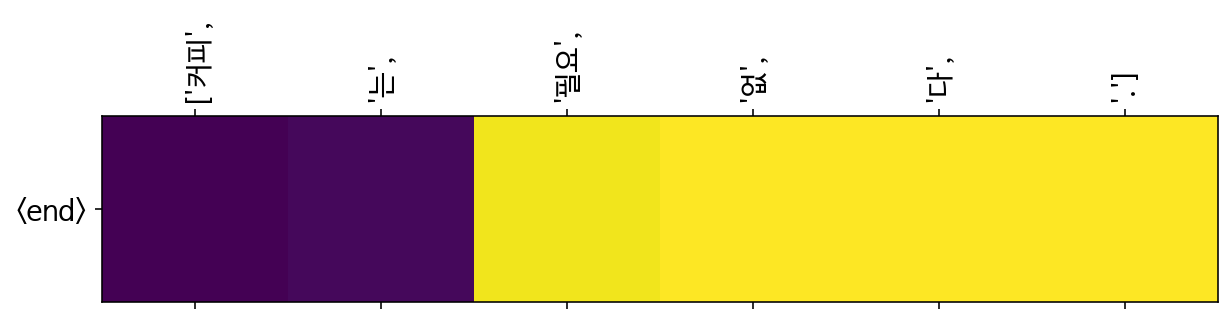

In [64]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: <end> 


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


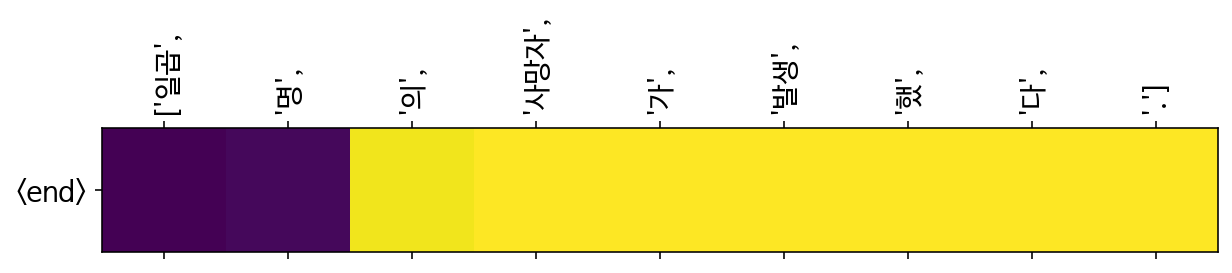

In [65]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

****
# 루브릭 평가

|평가문항|상세기준|
|:------|:-----|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|

1. 전처리는 정상적으로 처리했다고 생각한다.

2. 모델이 돌아가기는 했다. 하지만 loss가 안정적으로 떨어지는지는 그래프를 그리지 않아 확인해보지 못했다.

3. 미치고 팔짝 뛸 노릇이다. 분명 첫 시도에는 이상하지만 영어 문장이 나왔는데, 이제는 아예 영어 문장이 나오지 않는다. 아까랑 달라진 점이 없는데 왜 이러는지 정말 환장하겠다. 모델도 CUDA 에러랑 OOM 에러 때문에 안되다가 간신히 되게 돌려놨는데! 영어가 안나오다니! 머리 아프다... 

# 회고

정말 재밌는 프로젝트겠다하고 임했는데, 끝에 다다르니 허파가 뒤집어질 것 같다. 이걸 끝내고 한국어-힌디어 번역기를 만들어보면 좋겠다는 생각을 했었는데, 이미 그 생각은 기억의 저편으로 사라진 지 오래이다.


도대체 내가 무슨 잘못을 했길래 있었던 영어 문장이 없어진 걸까? 있었는데 없었습니다라는 말이 꼭 맞다. 머리가 터질 것 같아서 이대로 내려고 한다. 퍼실님께서 보시다가 문제점이 보이면 알려주시면 좋겠습니다...